<a href="https://colab.research.google.com/github/Nahmadid/sbinn/blob/main/JAX_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Drug_model_nn_JAX**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#@title **Importing libraries**
#Imports
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
!pip install optax
import optax
!pip install numba
import numba

In [ ]:

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def drug_model(
    t,
    kg = 0.72,
    kb = 0.15,
    G0 = 0.1,
):
    def func(y, t):
        G, B, U = y[0], y[1], y[2]

        return [
            - kg * G,
            kg * G - kb * B,
            kb * B,
            ]

    y0 = [G0, 0, 0]
    return odeint(func, y0, t)


t = np.arange(0, 50, 0.5)[:, None]
y = drug_model(np.ravel(t))


# Extract solution: G(t), IG(t), and Ip(t)

G = y[:, 0]
B = y[:, 1]
U = y[:, 2]

# # Save the variables to a file in your Google Drive
# data = np.savez('data.npz', G, B, U)
# np.savetxt("/content/drive/MyDrive/t_G_B_U.csv", np.column_stack((t, G, B, U)), delimiter=",")



In [ ]:
t_dense = jnp.linspace(0, 50, 501)[:, None]
y_dense = drug_model(np.ravel(t_dense))

sample_rate = 20
t_data = t_dense[::sample_rate,0:1]
G_data = y_dense[::sample_rate,0:1]
B_data = y_dense[::sample_rate,1:2]
U_data = y_dense[::sample_rate,2:3]

data = jnp.concatenate([G_data, B_data, U_data], axis=1)
t_i  = jnp.array([[0]])
IC   = jnp.concatenate([G_data[0:1,:], B_data[0:1,:], U_data[0:1,:]], axis=1)

print(t_data.shape)
print(data[:,[0,2]].shape)
print(IC.shape)




(26, 1)
(26, 2)
(1, 3)


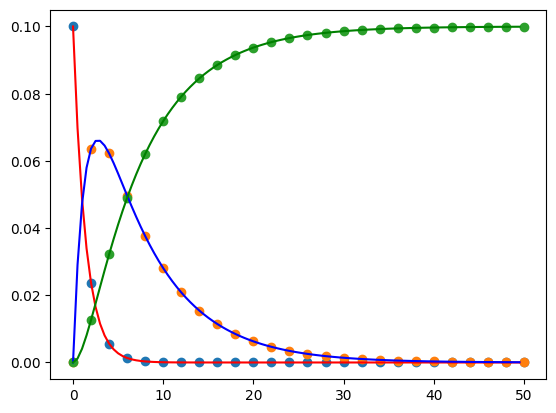

In [ ]:
plt.scatter(t_data, data[:,0:1])
plt.scatter(t_data, data[:,1:2])
plt.scatter(t_data, data[:,2:3])


plt.plot(t,y[:,0],'-r',label='G')
# plt.plot(t,np.exp(t),'--k',label='Analytical[1]')
plt.plot(t,y[:,1],'-b',label='B')
# plt.plot(t,0.5*np.exp(t)+1.5*np.exp(-t),'--b',label='Analytical[2]')
plt.plot(t,y[:,2],'-g',label='U')

In [ ]:
#@title **separate loss (na joda! oonam joda joda)**

# tmin,tmax=0.
tmin, tmax = t_dense[0,0], t_dense[-1,0]

#t = (t-np.min(t))/(np.max(t)-np.min(t))
def init_params(layers):
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in) # random initialization
        B = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B})
    return params


def fwd(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

def fwd_extra(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])

  X = X@last['W'] + last['B']
  # X = X**2
  return X



@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)



def ODE_loss(t, y1, y2, y3, f_t):
    kg = 0.72
    kb = 0.15
    G0 = 0.1
    # f_t=kg * y1(t) + kb * y2(t)

    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)
    y3_t = lambda t: jax.grad(lambda t: jnp.sum(y3(t)))(t)
    ode1 = y1_t(t) + kg * y1(t)
    ode2 = y2_t(t) - f_t(t)
    ode3 = y3_t(t) - kb * y2(t)

    return ode1, ode2, ode3




#collocation points
N_c = 1000

t_c = jnp.linspace(tmin, tmax, N_c+1)[:, None]

def loss_fun(params, params_extra, t_i, t_d, t_c, data_IC, data):

    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]
    f_t     = lambda t: fwd_extra(params_extra, t)[:, [0]]

    loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, y1_func, y2_func, y3_func, f_t)

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)


    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i), y3_func(t_i)],axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d    = t_d.flatten()[:,None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d)],axis=1)
    loss_data = MSE(data, pred_d)


    return loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3


def loss_fun_total(params, params_extra, t_i, t_d, t_c, data_IC, data, loss_weight):

    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3 = loss_fun(params, params_extra, t_i, t_d, t_c, data_IC, data)

    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
                + loss_weight[4]*loss_ode3

    return loss_total



# @jax.jit
# def update(opt_state,params, t_i, t_data, t_c, IC, data):
#   grads=jax.grad(loss_fun)(params, t_i, t_data, t_c, IC, data)

#   #Update params
#   updates, opt_state = optimizer.update(grads, opt_state)
#   params = optax.apply_updates(params, updates)
#   return opt_state,params

@jax.jit
def update(opt_state, opt_state_extra, params, params_extra, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0,1])(params, params_extra, t_i, t_data, t_c, IC, data, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
  params_extra = optax.apply_updates(params_extra, updates_extra)


  return opt_state,params,opt_state_extra,params_extra


# @jax.jit
# def update(opt_state, opt_state_extra, params, params_extra ,colloc,conds):
#   grads=jax.grad(loss_fun)(params,colloc,conds)

#   #Update params
#   updates, opt_state = optimizer.update(grads, opt_state)
#   params = optax.apply_updates(params, updates)

#   updates_extra, opt_state_extra = optimizer.update(grads, opt_state_extra)
#   params_extra = optax.apply_updates(params_extra, updates_extra)

#   return opt_state, opt_state_extra, params, params_extra

# construct the MLP of  4 hidden layers of 8 neurons for each layer
params = init_params([1] + [50]*6+[3])
params_extra = init_params([1] + [20]*4+[1])  # Initialize parameters for the extra neural network

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
optimizer_ex = optax.adam(1e-3)
opt_state_extra = optimizer_ex.init(params_extra)


In [ ]:
%%time
epochs =40000
loss_his, loss_indi_his, epoch_his = [], [], []
loss_weight = [1,20,1,30,1]
for ep in range(epochs+1):
  opt_state, params, opt_state_extra, params_extra = update(opt_state, opt_state_extra, params, params_extra, t_i, t_data, t_c, IC, data, loss_weight)

  # print loss and epoch info
  if ep %(1000) ==0:
    loss_val = loss_fun_total(params, params_extra,t_i, t_data, t_c, IC, data, loss_weight)
    loss_val_individual = loss_fun(params, params_extra,t_i, t_data, t_c, IC, data)
    epoch_his.append(ep)
    loss_his.append(loss_val)
    loss_indi_his.append(loss_val_individual)
    print(f'Epoch={ep}, \t loss={loss_val:.2e}, \t loss_IC={loss_val_individual[0]:.2e}, \t loss_d={loss_val_individual[1]:.2e}, \t loss_e1={loss_val_individual[2]:.2e}, \t loss_e2={loss_val_individual[3]:.2e}, \t loss_e3={loss_val_individual[4]:.2e}')


Epoch=0, 	 loss=4.12e-05, 	 loss_IC=1.34e-06, 	 loss_d=1.42e-06, 	 loss_e1=1.75e-06, 	 loss_e2=3.24e-07, 	 loss_e3=2.43e-08
Epoch=1000, 	 loss=1.98e-05, 	 loss_IC=8.48e-07, 	 loss_d=8.27e-07, 	 loss_e1=1.10e-06, 	 loss_e2=4.24e-08, 	 loss_e3=5.35e-09
Epoch=2000, 	 loss=7.96e-06, 	 loss_IC=3.43e-07, 	 loss_d=3.67e-07, 	 loss_e1=2.29e-07, 	 loss_e2=1.52e-09, 	 loss_e3=8.64e-09
Epoch=3000, 	 loss=1.14e-04, 	 loss_IC=2.67e-06, 	 loss_d=2.71e-06, 	 loss_e1=3.17e-06, 	 loss_e2=1.79e-06, 	 loss_e3=2.40e-08
Epoch=4000, 	 loss=3.17e-05, 	 loss_IC=1.60e-06, 	 loss_d=1.37e-06, 	 loss_e1=1.87e-06, 	 loss_e2=3.09e-08, 	 loss_e3=1.29e-08
Epoch=5000, 	 loss=1.29e-06, 	 loss_IC=6.23e-08, 	 loss_d=5.66e-08, 	 loss_e1=5.88e-08, 	 loss_e2=1.02e-09, 	 loss_e3=5.21e-09
Epoch=6000, 	 loss=1.46e-04, 	 loss_IC=2.83e-06, 	 loss_d=4.20e-06, 	 loss_e1=8.22e-07, 	 loss_e2=1.93e-06, 	 loss_e3=1.61e-07
Epoch=7000, 	 loss=1.02e-06, 	 loss_IC=4.35e-08, 	 loss_d=4.45e-08, 	 loss_e1=4.62e-08, 	 loss_e2=1.09e-09, 	 loss

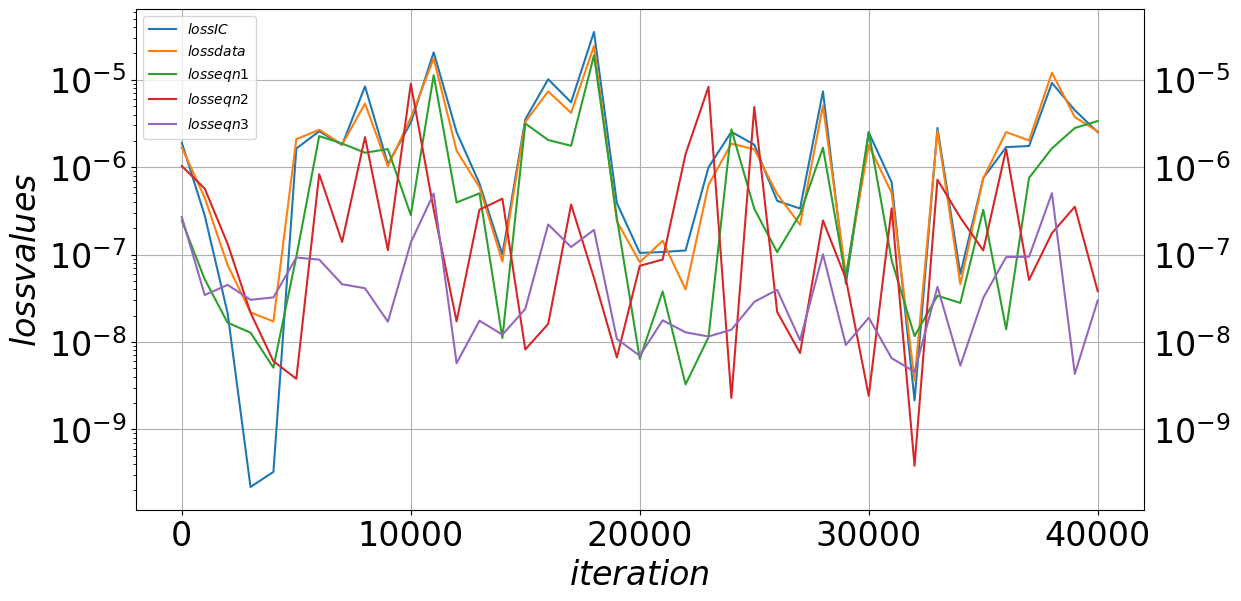

In [ ]:
SAVE_FIG = False
#History of loss
font = 24
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,0], label='$loss IC$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,1], label='$loss data$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,2], label='$loss eqn1$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,3], label='$loss eqn2$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,4], label='$loss eqn3$')
plt.legend(loc="upper right",  fontsize = 24, ncol=4)
plt.legend()
ax.tick_params(axis='both', labelsize = 24)
fig.set_size_inches(w=13,h=6.5)
if SAVE_FIG:
    plt.savefig(save_results_to +'History_loss.png', dpi=300)



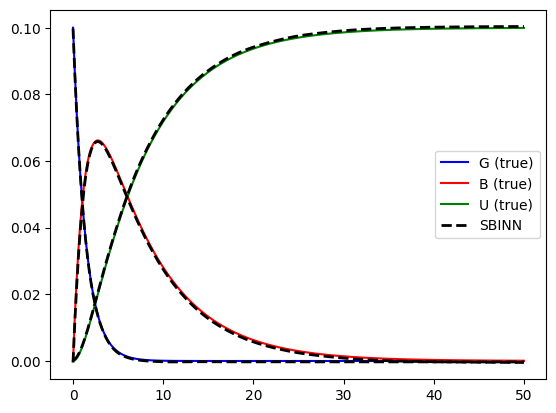

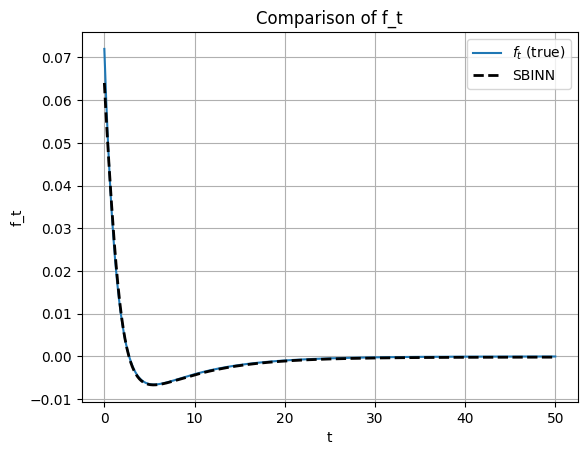

In [ ]:

# t = np.arange(0,50)
pred = fwd(params,t_dense)

plt.plot(t_dense, y_dense[:, 0:1],'-b',label='G (true)')
plt.plot(t_dense, y_dense[:, 1:2],'-r',label='B (true)')
plt.plot(t_dense, y_dense[:, 2:3],'-g',label='U (true)')

plt.plot(t_dense,pred[:,0],'--k',label='SBINN',linewidth=2)
plt.plot(t_dense,pred[:,1],'--k',linewidth=2)
plt.plot(t_dense,pred[:,2],'--k',linewidth=2)

# f_t =fwd(params_extra, t)
plt.legend()
plt.figure()



kg = 0.72
kb = 0.15
G0 = 0.1

# Calculate f_t using the provided equations
f_t_analytical = kg * y_dense[:, 0] - kb * y_dense[:, 1]
f_t_neural = fwd_extra(params_extra, t_dense)[:, 0]

# Plot both f_t values
plt.plot(t_dense, f_t_analytical, label='$f_t$ (true)')
plt.plot(t_dense, f_t_neural, label='SBINN')
plt.grid()
plt.xlabel('t')
plt.ylabel('f_t')
plt.title('Comparison of f_t')
# plt.legend()
# plt.show()



# plt.plot(T,fwd(params_extra,T.reshape(-1,1)),'--k',label='NN[G]',linewidth=2)

plt.legend()


In [ ]:
!pip install gplearn

In [ ]:

from gplearn.functions import make_function
import numpy as np

# Import necessary modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from gplearn.genetic import SymbolicRegressor
import pandas as pd


In [ ]:
df = pd.DataFrame({"t": np.ravel(t_dense),"G": np.ravel(y_dense[:, 0:1]), "B": np.ravel(y_dense[:, 1:2]), "fNN": np.ravel(f_t_neural) })
df.to_csv("/content/drive/MyDrive/f_t_26.csv", index=False)

In [ ]:
# data = np.column_stack((t_dense, f_t_neural))
# np.savetxt('/content/drive/MyDrive/f_t.csv', data, delimiter=',', header='t,f_t_values', comments='')

G_pred=pred[:,0]
B_pred=pred[:,1]

# df = pd.DataFrame({"t": np.ravel(t_dense),"G": np.ravel(G_pred), "B": np.ravel(B_pred), "fNN": np.ravel(f_t_neural) })
# df.to_csv("/content/drive/MyDrive/f_t.csv", index=False)


# Separate the data into the 'Ip', 'Ii' and 'f3' variables
data_X = np.column_stack((y_dense[:, 0:1], y_dense[:, 0:1]))  # Use 'G' and 'B' predictions as inputs

# Define and train the symbolic regressor
est_gp = SymbolicRegressor(population_size=20000,
                           generations=40, stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.03, random_state=0)

est_gp.fit(data_X, f_t_neural)

# Print the equation
print(est_gp._program)



    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.14           926785       15       0.00173414       0.00138272     16.79m
   1     6.83          2.09757       15       0.00167054       0.00194387     10.80m
   2     2.56          24.6516        3       0.00184865       0.00271889      9.20m
   3     1.57          119.031        5       0.00185696       0.00217039      8.42m
   4     1.57          3.46125        7         0.001816       0.00214969      8.53m
   5     1.59          3.39732        3       0.00184967       0.00269586      8.05m
   6     1.54          2.81639        7       0.00188351         0.002217      8.89m
   7     1.53          3.42298       13       0.00186844         0.001788      7.95m
   8     1.51          3.41812        5       0.00184913       0.00225659  

for 26 points:
-0.6210526315789474*X0 + 0.3171806167400881*X1


In [ ]:
# data = np.column_stack((t_dense, f_t_neural))
# np.savetxt('/content/drive/MyDrive/f_t.csv', data, delimiter=',', header='t,f_t_values', comments='')

G_pred=pred[:,0]
B_pred=pred[:,1]

df = pd.DataFrame({"t": np.ravel(t_dense),"G": np.ravel(G_pred), "B": np.ravel(B_pred), "fNN": np.ravel(f_t_neural) })
df.to_csv("/content/drive/MyDrive/f_t.csv", index=False)


# Separate the data into the 'Ip', 'Ii' and 'f3' variables
data_X = np.column_stack((pred[:, 0], pred[:, 1]))  # Use 'G' and 'B' predictions as inputs

# Define and train the symbolic regressor
est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

est_gp.fit(data_X, f_t_neural)

# Print the equation
print(est_gp._program)



    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13      5.93722e+06        7       0.00135268       0.00138294      1.84m
   1     7.04          11.9815        7       0.00139773      0.000985492      1.09m
   2     2.55          9.97156        3       0.00166752         0.002879     53.76s
   3     1.52          2.11444        7       0.00168283       0.00142085     50.08s
   4     1.54          13.4149        3       0.00177196       0.00192981     47.84s
   5     1.68          218.604        3        0.0017462       0.00264026     45.68s
   6     1.51          2.69784        3       0.00187858      0.000987606     43.47s
   7     1.59          26.3248        7       0.00182353       0.00146171     38.15s
   8     1.53         0.768169        3       0.00177919       0.00249816  

X0 = 0.956
X1 = 0.128

#**GLUC_INS_JAX**

In [ ]:
#@title **Importing libraries**
#Imports
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
!pip install optax
import optax
!pip install numba
import numba



In [ ]:
#@title **GLU_INS**

import numpy as np
from scipy.integrate import odeint

#Defining the model
def glucose_insulin_model(
    t,
    meal_t,
    meal_q,
    Vp=3,
    Vi=11,
    Vg=10,
    E=0.2,
    tp=6,
    ti=100,
    td=12,
    k=1 / 120,
    Rm=209,
    a1=6.6,
    C1=300,
    C2=144,
    C3=100,
    C4=80,
    C5=26,
    Ub=72,
    U0=4,
    Um=90,
    Rg=180,
    alpha=7.5,
    beta=1.772,
):
    def func(y, t):
        f1 = Rm / (1 + np.exp(-y[2] / Vg / C1 + a1))
        f2 = Ub * (1 - np.exp(-y[2] / Vg / C2))
        kappa = (1 / Vi + 1 / E / ti) / C4
        f3 = (U0 + Um / (1 + (kappa * y[1]) ** (-beta))) / Vg / C3
        f4 = Rg / (1 + np.exp(alpha * (y[5] / Vp / C5 - 1)))
        IG = np.sum(
            meal_q * k * np.exp(k * (meal_t - t)) *
            np.heaviside(t - meal_t, 0.5)
        )
        tmp = E * (y[0] / Vp - y[1] / Vi)
        return [
            f1 - tmp - y[0] / tp,
            tmp - y[1] / ti,
            f4 + IG - f2 - f3 * y[2],
            (y[0] - y[3]) / td,
            (y[3] - y[4]) / td,
            (y[4] - y[5]) / td,
        ]

    # defining initial conditions for 6 state variables
    Vp0, Vi0, Vg0 = 3, 11, 10
    y0 = [12 * Vp0, 4 * Vi0, 110 * Vg0 ** 2, 0, 0, 0]
    return odeint(func, y0, t)

#Giving the data of time and quantity of meal intake
meal_t = np.array([300, 650, 1100, 2000])
meal_q = np.array([60e3, 40e3, 50e3, 100e3])

#solving the model with the given inputs
t = np.arange(0, 1800, 1)[:, None]
y = glucose_insulin_model(np.ravel(t), meal_t, meal_q)

#saving the data which is generated by solving the equation in google drive
# np.savetxt("/content/drive/MyDrive/glucose.dat", np.hstack((t, y)))
# np.savetxt("/content/drive/MyDrive/meal.dat",
#            np.hstack((meal_t, meal_q)))

#defining the solutions of ODEs and scaling G(t)


In [ ]:
t_dense = jnp.linspace(0, 1800, 1801)[:, None]
y_dense_org = glucose_insulin_model(np.ravel(t_dense),meal_t, meal_q)

scale_factor = [1,1,100,1,1,1]
y_dense = y_dense_org/scale_factor

sample_rate = 5
t_data = t_dense[::sample_rate,0:1]
Ip_data = y_dense[::sample_rate,0:1]
Ii_data = y_dense[::sample_rate,1:2]
G_data = y_dense[::sample_rate,2:3]
h1_data = y_dense[::sample_rate,3:4]
h2_data = y_dense[::sample_rate,4:5]
h3_data = y_dense[::sample_rate,5:6]


data = jnp.concatenate([Ip_data, Ii_data, G_data, h1_data, h2_data, h3_data], axis=1)
t_i  = jnp.array([[0]])
IC   = jnp.concatenate([Ip_data[0:1,:], Ii_data[0:1,:], G_data[0:1,:], h1_data[0:1,:], h2_data[0:1,:], h3_data[0:1,:]], axis=1)
# t=t_data
# B=jnp.concatenate(
#         (t, jnp.sin(t), jnp.sin(2 * t), jnp.sin(3 * t), jnp.sin(4 * t), jnp.sin(5 * t)),
#         axis=1,
#     )


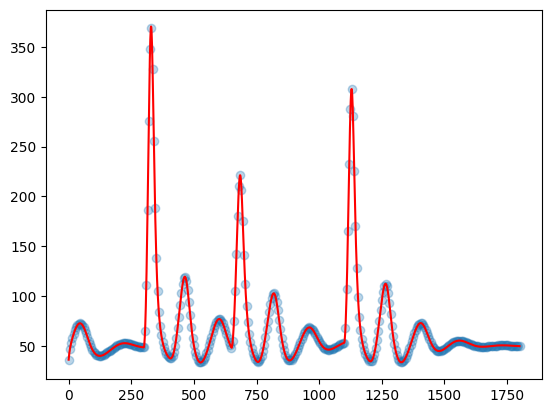

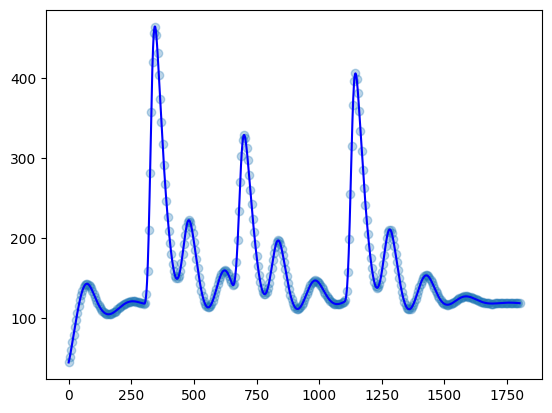

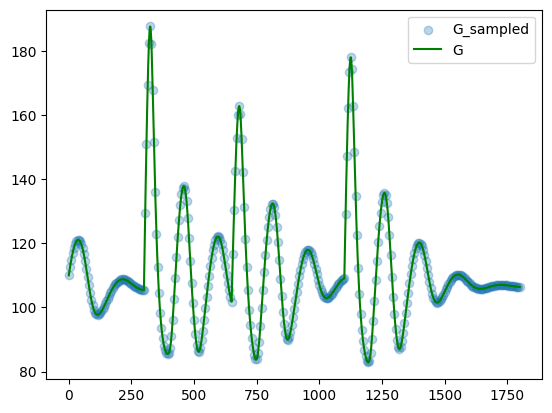

In [ ]:

plt.figure()
plt.scatter(t_data, data[:,0:1], alpha=0.3)
plt.plot(t_dense,y_dense[:,0],'-r',label='Ip')

plt.figure()
plt.scatter(t_data, data[:,1:2], alpha=0.3)
plt.plot(t_dense,y_dense[:,1],'-b',label='Ii')

plt.figure()
plt.scatter(t_data, data[:,2:3], alpha=0.3,label='G_sampled')
plt.plot(t_dense,y_dense[:,2],'-g',label='G')
plt.legend()



In [ ]:
# tmin,tmax=0.
tmin, tmax = t_dense[0,0], t_dense[-1,0]

#t = (t-np.min(t))/(np.max(t)-np.min(t))
def init_params(layers):
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in) # random initialization
        B = jax.random.normal(key, shape=(n_out,))
        params.append({'W': W, 'B': B})
    return params

#_________________With feature layer______________________
def feature_transform(t):
    t = 0.01 * t
    return jnp.concatenate(
        (t, jnp.sin(t), jnp.sin(2 * t), jnp.sin(3 * t), jnp.sin(4 * t), jnp.sin(5 * t)),
        axis=1,
    )

def fwd(params, t):
    X = feature_transform(t)  # Apply the feature_transform to input t
    *hidden, last = params
    for layer in hidden:
        X = jax.nn.tanh(X @ layer['W'] + layer['B'])
    return X @ last['W'] + last['B']

#__________________extra__________________________________________

def fwd_f(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])

  X = X@last['W'] + last['B']
  return X

def fwd_g(params,t):
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])

  X = X@last['W'] + last['B']
  return X


# #_______________________________________________________

# def fwd(params,t):
#   X = jnp.concatenate([t],axis=1)
#   *hidden,last = params
#   for layer in hidden :
#     X = jax.nn.tanh(X@layer['W']+layer['B'])
#     # X = jnp.sin(X@layer['W']+layer['B'])
#   return X@last['W'] + last['B']


# def fwd_extra(params,t):
#   X = jnp.concatenate([t],axis=1)
#   *hidden,last = params
#   for layer in hidden :
#     X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])

  # X = X@last['W'] + last['B']
  # # X = X**2
  # return X


#__________________________________


# def output_transform(t, y):
#     idx = 1799
#     k = (data_y[idx] - data_y[0]) / (data_t[idx] - data_t[0])
#     b = (data_t[idx] * data_y[0] - data_t[0] * data_y[idx]) / (data_t[idx] - data_t[0])
#     linear = k * t + b
#     factor = jnp.tanh(t) * jnp.tanh(idx - t)
#     return linear + factor * jnp.array([1, 1, 1e2, 1, 1, 1]) * y

# def output_transform(t_dense, y_dense):


#     k = (y_dense[-1,0] - y_dense[0,0]) / (t_dense[-1,0] - t_dense[0,0])
#     b = (t_dense[-1,0] * y_dense[0,0] - t_dense[0,0] * y_dense[-1,0]) / (t_dense[-1,0] - t_dense[0,0])
#     linear = k * t + b
#     factor = jnp.tanh(t) * jnp.tanh(idx - t)
#     return linear + factor * jnp.array([1, 1, 1e2, 1, 1, 1]) * y





#__________________________________

@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)




In [ ]:
#@title **Inverse**
def ODE_loss(t, y1, y2, y3, y4, y5, y6, f_t, g_t):
    Vp=3
    Vi=11
    Vg=10
    E=0.2
    tp=6
    ti=100
    td=12
    k=1 / 120
    Rm=209
    a1=6.6
    C1=300
    C2=144
    C3=100
    C4=80
    C5=26
    Ub=72
    U0=4
    Um=90
    Rg=180
    alpha=7.5
    beta=1.772


    Ip = y1(t)*scale_factor[0]
    Ii = y2(t)*scale_factor[1]
    G  = y3(t)*scale_factor[2]
    h1 = y4(t)*scale_factor[3]
    h2 = y5(t)*scale_factor[4]
    h3 = y6(t)*scale_factor[5]

    meal_t = np.array([300, 650, 1100, 2000])
    meal_q = np.array([60e3, 40e3, 50e3, 100e3])

    f1 = Rm * jax.nn.sigmoid(G / (Vg * C1) - a1)
    f2 = Ub * (1 - jnp.exp(-G / (Vg * C2)))
    kappa = (1 / Vi + 1 / (E * ti)) / C4
    f3 = (U0 + Um / (1 + jnp.power(jnp.maximum(kappa * Ii, 1e-3), -beta))) / (Vg * C3)
    f4 = Rg * jax.nn.sigmoid(alpha * (1 - h3 / (Vp * C5)))

    dt = t - meal_t
    IG = jnp.sum(0.5 * meal_q * k * jnp.exp(-k * dt) * (jnp.sign(dt) + 1), axis=1, keepdims=True)

    # tmp = E * (Ip / Vp - Ii / Vi)




    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)
    y3_t = lambda t: jax.grad(lambda t: jnp.sum(y3(t)))(t)
    y4_t = lambda t: jax.grad(lambda t: jnp.sum(y4(t)))(t)
    y5_t = lambda t: jax.grad(lambda t: jnp.sum(y5(t)))(t)
    y6_t = lambda t: jax.grad(lambda t: jnp.sum(y6(t)))(t)

    # y1_t = y1_t*scale_factor[0]
    # y2_t = y2_t*scale_factor[1]
    # y3_t = y3_t*scale_factor[2]
    # y4_t = y4_t*scale_factor[3]
    # y5_t = y5_t*scale_factor[4]
    # y6_t = y6_t*scale_factor[5]


    ode1 = y1_t(t)*scale_factor[0] - (f1 + f_t(t))
    ode2 = y2_t(t)*scale_factor[1] - (g_t(t))
    ode3 = y3_t(t)*scale_factor[2] - (f4 + IG - f2 - f3 * G)
    ode4 = y4_t(t)*scale_factor[3] - (Ip - h1) / td
    ode5 = y5_t(t)*scale_factor[4] - (h1 - h2) / td
    ode6 = y6_t(t)*scale_factor[5] - (h2 - h3) / td

    return ode1, ode2, ode3, ode4, ode5, ode6



#collocation points
N_c = 1800

t_c = jnp.linspace(tmin, tmax, N_c+1)[:, None]

def loss_fun(params, params_f, params_g, t_i, t_d, t_c, data_IC, data):

    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]
    y4_func = lambda t: fwd(params, t)[:, [3]]
    y5_func = lambda t: fwd(params, t)[:, [4]]
    y6_func = lambda t: fwd(params, t)[:, [5]]

    f_t     = lambda t: fwd_f(params_f, t)[:, [0]]
    g_t     = lambda t: fwd_g(params_g, t)[:, [0]]

    loss_y1, loss_y2, loss_y3, loss_y4, loss_y5, loss_y6 = ODE_loss(t_c, y1_func, y2_func, y3_func, y4_func, y5_func, y6_func, f_t, g_t)

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)
    loss_ode4 = jnp.mean(loss_y4 ** 2)
    loss_ode5 = jnp.mean(loss_y5 ** 2)
    loss_ode6 = jnp.mean(loss_y6 ** 2)


    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i), y3_func(t_i), y4_func(t_i), y5_func(t_i), y6_func(t_i)],axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d    = t_d.flatten()[:,None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d), y4_func(t_d), y5_func(t_d), y6_func(t_d)],axis=1)
    # loss_data = MSE(data, pred_d)
    # pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d)],axis=1)
    loss_data = MSE(data[:,0:3], pred_d[:,0:3])

    return loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4, loss_ode5, loss_ode6


def loss_fun_total(params, params_f, params_g, t_i, t_d, t_c, data_IC, data, loss_weight):

    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4, loss_ode5, loss_ode6= loss_fun(params, params_f, params_g, t_i, t_d, t_c, data_IC, data)


    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
                + loss_weight[4]*loss_ode3 + loss_weight[5]*loss_ode4 + loss_weight[6]*loss_ode5 + loss_weight[7]*loss_ode6

    return loss_total

@jax.jit
def update(opt_state, opt_state_f, opt_state_g, params, params_f, params_g, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0,1,2])(params, params_f, params_g, t_i, t_data, t_c, IC, data, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  updates_f, opt_state_f = optimizer.update(grads[1], opt_state_f)
  params_f = optax.apply_updates(params_f, updates_f)

  updates_g, opt_state_g = optimizer.update(grads[2], opt_state_g)
  params_g = optax.apply_updates(params_g, updates_g)

  return opt_state, params, opt_state_f, params_f, opt_state_g, params_g


# @jax.jit
# def update(opt_state, params, t_i, t_data, t_c, IC, data, loss_weight):
#   grads=jax.grad(loss_fun_total)(params, t_i, t_data, t_c, IC, data, loss_weight)
#   #Update params
#   updates, opt_state = optimizer.update(grads, opt_state)
#   params = optax.apply_updates(params, updates)
#   return opt_state,params

# # construct the MLP of  4 hidden layers of 8 neurons for each layer
params = init_params([6] + [128]*3+[6])
params_f = init_params([1] + [15]*3+[1])
params_g = init_params([1] + [15]*3+[1])

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
opt_state_f = optimizer.init(params_f)
opt_state_g = optimizer.init(params_g)

In [ ]:
# loss_fun_total(params, params_f, params_g, t_i, t_data, t_c, IC, data, loss_weight)
# loss_fun(params, params_f, params_g, t_i, t_data, t_c, IC, data)
# temp_f_t     = lambda t: fwd_f(params_f, t)[:, [0]]
# temp_f_t(t_i)

In [ ]:
#@title **Forward**
def ODE_loss(t, y1, y2, y3, y4, y5, y6):
    Vp=3
    Vi=11
    Vg=10
    E=0.2
    tp=6
    ti=100
    td=12
    k=1 / 120
    Rm=209
    a1=6.6
    C1=300
    C2=144
    C3=100
    C4=80
    C5=26
    Ub=72
    U0=4
    Um=90
    Rg=180
    alpha=7.5
    beta=1.772


    Ip = y1(t)*scale_factor[0]
    Ii = y2(t)*scale_factor[1]
    G  = y3(t)*scale_factor[2]
    h1 = y4(t)*scale_factor[3]
    h2 = y5(t)*scale_factor[4]
    h3 = y6(t)*scale_factor[5]

    meal_t = np.array([300, 650, 1100, 2000])
    meal_q = np.array([60e3, 40e3, 50e3, 100e3])

    f1 = Rm * jax.nn.sigmoid(G / (Vg * C1) - a1)
    f2 = Ub * (1 - jnp.exp(-G / (Vg * C2)))
    kappa = (1 / Vi + 1 / (E * ti)) / C4
    f3 = (U0 + Um / (1 + jnp.power(jnp.maximum(kappa * Ii, 1e-3), -beta))) / (Vg * C3)
    f4 = Rg * jax.nn.sigmoid(alpha * (1 - h3 / (Vp * C5)))

    dt = t - meal_t
    IG = jnp.sum(0.5 * meal_q * k * jnp.exp(-k * dt) * (jnp.sign(dt) + 1), axis=1, keepdims=True)

    tmp = E * (Ip / Vp - Ii / Vi)




    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)
    y3_t = lambda t: jax.grad(lambda t: jnp.sum(y3(t)))(t)
    y4_t = lambda t: jax.grad(lambda t: jnp.sum(y4(t)))(t)
    y5_t = lambda t: jax.grad(lambda t: jnp.sum(y5(t)))(t)
    y6_t = lambda t: jax.grad(lambda t: jnp.sum(y6(t)))(t)

    # y1_t = y1_t*scale_factor[0]
    # y2_t = y2_t*scale_factor[1]
    # y3_t = y3_t*scale_factor[2]
    # y4_t = y4_t*scale_factor[3]
    # y5_t = y5_t*scale_factor[4]
    # y6_t = y6_t*scale_factor[5]


    ode1 = y1_t(t)*scale_factor[0] - (f1 - tmp - Ip / tp)
    ode2 = y2_t(t)*scale_factor[1] - (tmp - Ii / ti)
    ode3 = y3_t(t)*scale_factor[2] - (f4 + IG - f2 - f3 * G)
    ode4 = y4_t(t)*scale_factor[3] - (Ip - h1) / td
    ode5 = y5_t(t)*scale_factor[4] - (h1 - h2) / td
    ode6 = y6_t(t)*scale_factor[5] - (h2 - h3) / td

    return ode1, ode2, ode3, ode4, ode5, ode6



#collocation points
N_c = 1000

t_c = jnp.linspace(tmin, tmax, N_c+1)[:, None]

def loss_fun(params,t_i, t_d, t_c, data_IC, data):

    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    y3_func = lambda t: fwd(params, t)[:, [2]]
    y4_func = lambda t: fwd(params, t)[:, [3]]
    y5_func = lambda t: fwd(params, t)[:, [4]]
    y6_func = lambda t: fwd(params, t)[:, [5]]

    # f_t     = lambda t: fwd_extra(params_extra, t)[:, [0]]

    loss_y1, loss_y2, loss_y3, loss_y4, loss_y5, loss_y6 = ODE_loss(t_c, y1_func, y2_func, y3_func, y4_func, y5_func, y6_func)

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)
    loss_ode3 = jnp.mean(loss_y3 ** 2)
    loss_ode4 = jnp.mean(loss_y4 ** 2)
    loss_ode5 = jnp.mean(loss_y5 ** 2)
    loss_ode6 = jnp.mean(loss_y6 ** 2)


    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i), y3_func(t_i), y4_func(t_i), y5_func(t_i), y6_func(t_i)],axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d    = t_d.flatten()[:,None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d), y4_func(t_d), y5_func(t_d), y6_func(t_d)],axis=1)
    # loss_data = MSE(data, pred_d)
    # pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d), y3_func(t_d)],axis=1)
    loss_data = MSE(data[:,0:3], pred_d[:,0:3])

    return loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4, loss_ode5, loss_ode6


def loss_fun_total(params, t_i, t_d, t_c, data_IC, data, loss_weight):

    # loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4, loss_ode5, loss_ode6= loss_fun(params, t_i, t_d, t_c, data_IC, data)
    loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3, loss_ode4, loss_ode5, loss_ode6= loss_fun(params, t_i, t_d, t_c, data_IC, data)


    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
                + loss_weight[4]*loss_ode3 + loss_weight[5]*loss_ode4 + loss_weight[6]*loss_ode5 + loss_weight[7]*loss_ode6

    return loss_total


@jax.jit
def update(opt_state, params, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total)(params, t_i, t_data, t_c, IC, data, loss_weight)
  #Update params
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return opt_state,params

# construct the MLP of  4 hidden layers of 8 neurons for each layer
params = init_params([6] + [128]*3+[6])

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)


In [ ]:
%%time
epochs =200000
loss_his, loss_indi_his, epoch_his = [], [], []
loss_weight = [1,1,1,1,1,1,1,1]
for ep in range(epochs+1):
  opt_state, params, opt_state_f, params_f, opt_state_g, params_g = update(opt_state, opt_state_f, opt_state_g, params, params_f, params_g, t_i, t_data, t_c, IC, data, loss_weight)

  # print loss and epoch info
  if ep %(1000) ==0:
    loss_val = loss_fun_total(params, params_f, params_g ,t_i, t_data, t_c, IC, data, loss_weight)
    loss_val_individual = loss_fun(params, params_f, params_g, t_i, t_data, t_c, IC, data)
    epoch_his.append(ep)
    loss_his.append(loss_val)
    loss_indi_his.append(loss_val_individual)
    print(f'Epoch={ep}, \t loss={loss_val:.2e}, \t loss_IC={loss_val_individual[0]:.2e}, \t loss_d={loss_val_individual[1]:.2e}, \t loss_e1={loss_val_individual[2]:.2e}, \t loss_e2={loss_val_individual[3]:.2e}, \t loss_e3={loss_val_individual[4]:.2e}, \t loss_e3={loss_val_individual[5]:.2e}, \t loss_e3={loss_val_individual[6]:.2e}, \t loss_e3={loss_val_individual[7]:.2e}')


Epoch=201000, 	 loss=1.68e+01, 	 loss_IC=9.53e-05, 	 loss_d=6.37e+00, 	 loss_e1=9.29e+00, 	 loss_e2=7.24e-01, 	 loss_e3=1.27e-01, 	 loss_e3=6.61e-02, 	 loss_e3=9.60e-02, 	 loss_e3=1.58e-01
Epoch=202000, 	 loss=1.68e+01, 	 loss_IC=4.60e-04, 	 loss_d=6.34e+00, 	 loss_e1=9.24e+00, 	 loss_e2=7.22e-01, 	 loss_e3=1.52e-01, 	 loss_e3=6.57e-02, 	 loss_e3=9.64e-02, 	 loss_e3=1.58e-01
Epoch=203000, 	 loss=1.68e+01, 	 loss_IC=1.61e-04, 	 loss_d=6.36e+00, 	 loss_e1=9.37e+00, 	 loss_e2=7.19e-01, 	 loss_e3=2.52e-02, 	 loss_e3=6.57e-02, 	 loss_e3=9.60e-02, 	 loss_e3=1.58e-01
Epoch=204000, 	 loss=1.65e+01, 	 loss_IC=1.21e-04, 	 loss_d=6.34e+00, 	 loss_e1=9.05e+00, 	 loss_e2=7.18e-01, 	 loss_e3=1.08e-01, 	 loss_e3=6.56e-02, 	 loss_e3=9.62e-02, 	 loss_e3=1.58e-01
Epoch=205000, 	 loss=1.67e+01, 	 loss_IC=1.03e-04, 	 loss_d=6.35e+00, 	 loss_e1=9.22e+00, 	 loss_e2=7.31e-01, 	 loss_e3=7.00e-02, 	 loss_e3=6.59e-02, 	 loss_e3=9.58e-02, 	 loss_e3=1.57e-01
Epoch=206000, 	 loss=1.66e+01, 	 loss_IC=2.38e-04, 	 lo

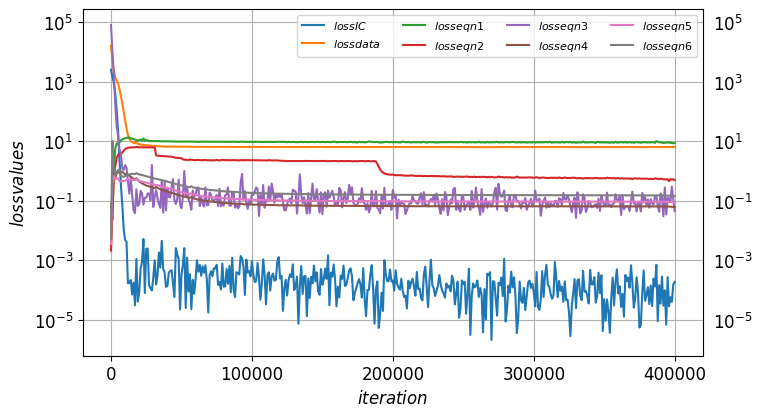

In [ ]:
SAVE_FIG = False
#History of loss
font = 12
w_size, h_size = 8, 4.5

fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,0], label='$loss IC$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,1], label='$loss data$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,2], label='$loss eqn1$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,3], label='$loss eqn2$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,4], label='$loss eqn3$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,5], label='$loss eqn4$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,6], label='$loss eqn5$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,7], label='$loss eqn6$')
plt.legend(loc="upper right",  fontsize = 8, ncol=4)
# plt.legend()
ax.tick_params(axis='both', labelsize = 12)
fig.set_size_inches(w=w_size,h=h_size)
if SAVE_FIG:
    plt.savefig(save_results_to +'History_loss.png', dpi=300)

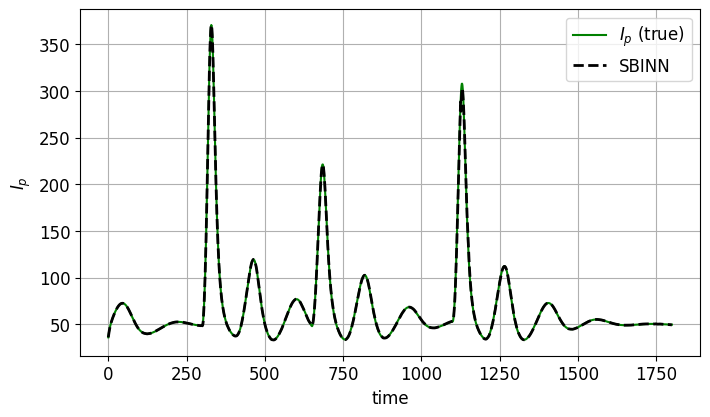

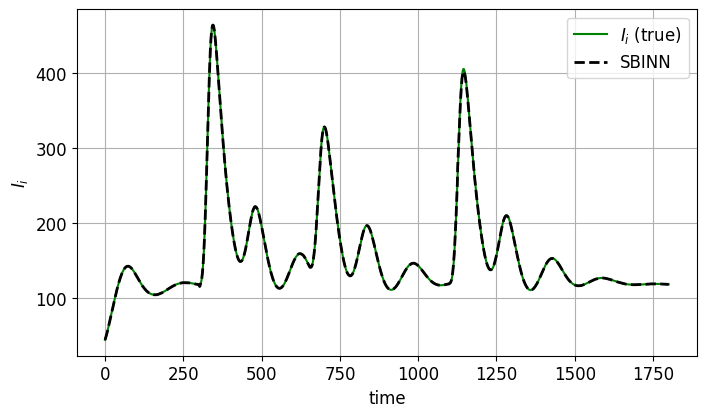

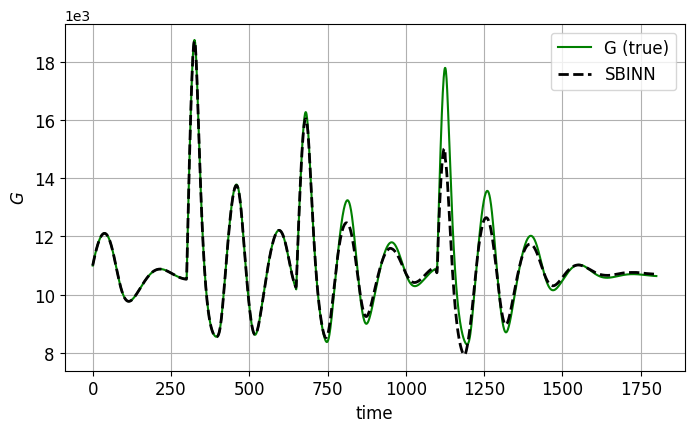

In [ ]:
pred = fwd(params,t_dense)

SAVE_FIG = False
font = 12
labelsize =12
w_size, h_size = 8, 4.5

fig, ax = plt.subplots()
ax.plot(t_dense, y_dense[:, 0:1]*scale_factor[0],'-g',label='$I_p$ (true)')
ax.plot(t_dense, pred[:,0]*scale_factor[0],'--k',linewidth=2, label='SBINN')
# ax.set_xlim(0-0.5,180)
# ax.set_ylim(0-0.5,6000+0.5)
ax.legend(fontsize=font)
ax.tick_params(axis='both', labelsize = labelsize)
# ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax.grid(True)
ax.set_xlabel('time', fontsize = font)
ax.set_ylabel('$I_p$', fontsize = font)
fig.set_size_inches(w=w_size,h=h_size)
if SAVE_FIG:
    plt.savefig(save_results_to +'G.png', dpi=300)

fig, ax = plt.subplots()
ax.plot(t_dense, y_dense[:, 1:2]*scale_factor[1],'-g',label='$I_i$ (true)')
ax.plot(t_dense, pred[:,1]*scale_factor[1],'--k',linewidth=2, label='SBINN')
# ax.set_xlim(0-0.5,180)
# ax.set_ylim(0-0.5,6000+0.5)
ax.legend(fontsize=font)
ax.tick_params(axis='both', labelsize = labelsize)
# ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax.grid(True)
ax.set_xlabel('time', fontsize = font)
ax.set_ylabel('$I_i$', fontsize = font)
fig.set_size_inches(w=w_size,h=h_size)
if SAVE_FIG:
    plt.savefig(save_results_to +'G.png', dpi=300)


fig, ax = plt.subplots()
ax.plot(t_dense, y_dense[:, 2:3]*scale_factor[2],'-g',label='G (true)')
ax.plot(t_dense, pred[:,2]*scale_factor[2],'--k',linewidth=2, label='SBINN')
# ax.set_xlim(0-0.5,180)
# ax.set_ylim(0-0.5,6000+0.5)
ax.legend(fontsize=font)
ax.tick_params(axis='both', labelsize = labelsize)
ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax.grid(True)
ax.set_xlabel('time', fontsize = font)
ax.set_ylabel('$G$', fontsize = font)
fig.set_size_inches(w=w_size,h=h_size)
if SAVE_FIG:
    plt.savefig(save_results_to +'G.png', dpi=300)



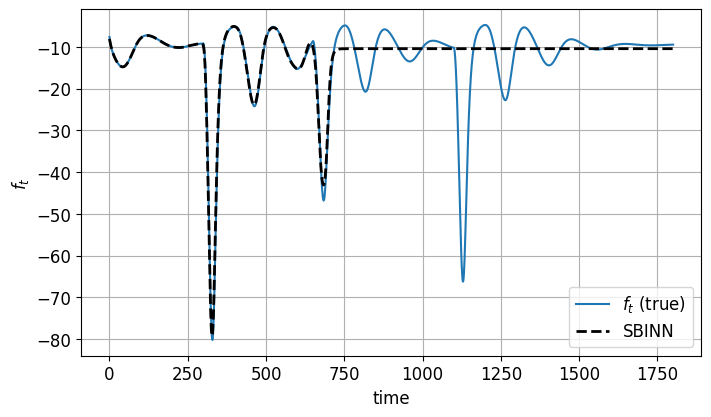

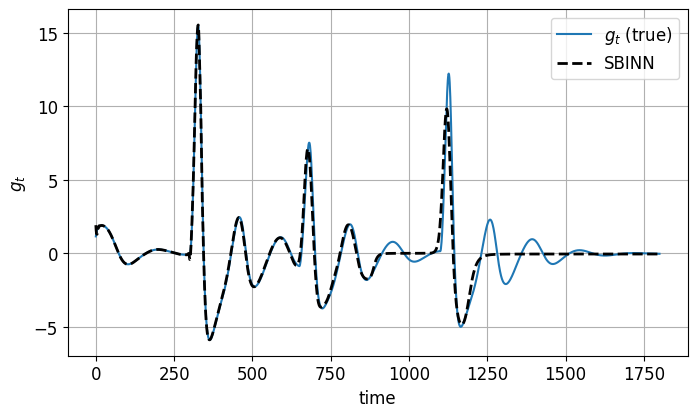

In [ ]:
Vp=3
Vi=11
Vg=10
E=0.2
tp=6
ti=100
td=12


Ip_true = y_dense[:, 0:1]*scale_factor[0]
Ii_true = y_dense[:, 1:2]*scale_factor[1]

f_t_true = -E * (Ip_true / Vp - Ii_true / Vi) - Ip_true/tp
g_t_true =  E * (Ip_true / Vp - Ii_true / Vi) - Ii_true/ti

f_t_pred = fwd_f(params_f, t_dense)[:,0]
g_t_pred = fwd_g(params_g, t_dense)[:,0]



SAVE_FIG = False
font = 12
labelsize =12
w_size, h_size = 8, 4.5

fig, ax = plt.subplots()
ax.plot(t_dense, f_t_true, label='$f_t$ (true)')
ax.plot(t_dense, f_t_pred,'--k',linewidth=2, label='SBINN')
# ax.set_xlim(0-0.5,180)
# ax.set_ylim(0-0.5,6000+0.5)
ax.legend(fontsize=font)
ax.tick_params(axis='both', labelsize = labelsize)
# ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax.grid(True)
ax.set_xlabel('time', fontsize = font)
ax.set_ylabel('$f_t$', fontsize = font)
fig.set_size_inches(w=w_size,h=h_size)
if SAVE_FIG:
    plt.savefig(save_results_to +'G.png', dpi=300)


fig, ax = plt.subplots()
ax.plot(t_dense, g_t_true, label='$g_t$ (true)')
ax.plot(t_dense, g_t_pred,'--k',linewidth=2, label='SBINN')
# ax.set_xlim(0-0.5,180)
# ax.set_ylim(0-0.5,6000+0.5)
ax.legend(fontsize=font)
ax.tick_params(axis='both', labelsize = labelsize)
# ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax.grid(True)
ax.set_xlabel('time', fontsize = font)
ax.set_ylabel('$g_t$', fontsize = font)
fig.set_size_inches(w=w_size,h=h_size)
if SAVE_FIG:
    plt.savefig(save_results_to +'G.png', dpi=300)
